In [95]:
import os
from pathlib import Path
import datetime as dt

import numpy as np
from numpy.fft import rfft, irfft

import cv2
import SimpleITK as sitk
import pydicom

from scipy.optimize import curve_fit

In [96]:
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

Number of masks: 2
Shape of first mask: (256, 192)


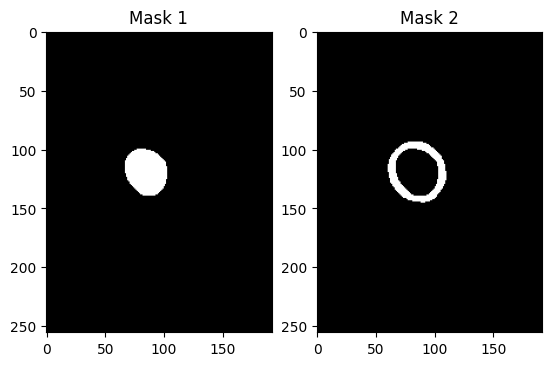

In [97]:
# Load all pages from the TIFF
success, images = cv2.imreadmulti("./data/AIF_And_Myo_Masks.tiff", [], cv2.IMREAD_UNCHANGED)

if not success:
    raise ValueError("Could not read TIFF file")

print(f"Number of masks: {len(images)}")
print(f"Shape of first mask: {images[0].shape}")

# Display the masks
plt.subplot(1, 2, 1)
ventr_mask = images[0]
plt.imshow(ventr_mask, cmap='gray')
plt.title("Mask 1")

plt.subplot(1, 2, 2)
myo_mask = images[1]
plt.imshow(myo_mask, cmap='gray')
plt.title("Mask 2")
plt.show()

# fig = make_subplots(
#     rows=1, cols=2,
#     subplot_titles=["Mask 1", "Mask 2"],
#     horizontal_spacing=0.05
# )

# fig.add_trace(px.imshow(images[0], color_continuous_scale="gray_r").data[0], row=1, col=1)
# fig.add_trace(px.imshow(images[1], color_continuous_scale="gray_r").data[0], row=1, col=2)

# fig.update_layout(
#     height=400,
#     width=800,
#     coloraxis_showscale=False,
#     title_text="Masks comparison (black/white)"
# )
# fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
# fig.show()

In [98]:
ventr_mask.shape

(256, 192)

In [99]:
dcm_dir_path = Path("./data/MotionCorrectedPerfusionSeries/")

reader = sitk.ImageSeriesReader()
files = reader.GetGDCMSeriesFileNames(dcm_dir_path)
reader.SetFileNames(files)
img = reader.Execute()

arr = sitk.GetArrayFromImage(img)
vol = arr.astype(np.float32)
spacing = img.GetSpacing() 
direction = img.GetDirection()
origin = img.GetOrigin()
print(vol.shape, spacing, direction, origin)

(58, 256, 192) (1.7578125, 1.7578125, 1.0) (0.5227459375169434, -0.41352397948139147, -0.7454760916376899, 0.818760614753185, -4.0637000999382724e-07, 0.5741350500786565, -0.2374189136074009, -0.9104932280877812, 0.3385769352270957) (62.809025873629, -149.70701062788, 188.39999684842)


In [100]:
vol_ventr = np.where(ventr_mask, vol, 0)

In [101]:
vol_myo = np.where(myo_mask, vol, 0)

In [102]:
# roi check

# plt.subplot(1, 2, 1)
# plt.imshow(vol_ventr[ts_idx, :, :], cmap='gray')
# plt.title("RoI ventr")

# plt.subplot(1, 2, 2)
# plt.imshow(vol_myo[ts_idx, :, :], cmap='gray')
# plt.title("RoI myo")

import plotly.express as px
from plotly.subplots import make_subplots

ts_idx = 5
fig = make_subplots(rows=1, cols=2, subplot_titles=["RoI blood pool", "RoI myo"])

fig.add_trace(px.imshow(vol_ventr[ts_idx, :, :], color_continuous_scale='gray').data[0], row=1, col=1)
fig.add_trace(px.imshow(vol_myo[ts_idx, :, :], color_continuous_scale='gray').data[0], row=1, col=2)

# fig.update_layout(height=400, width=800)
fig.show()

In [69]:
vol_ventr.shape

(58, 256, 192)

In [70]:
filenames = os.listdir(dcm_dir_path)

times = []
for filename in filenames:
    ds = pydicom.dcmread(dcm_dir_path / filename, stop_before_pixels=True)
    tstr = getattr(ds, "AcquisitionTime", None) or getattr(ds, "ContentTime", None)
    if tstr and len(tstr) >= 6:
        # convert "hhmmss.frac" → seconds
        h, m, s = int(tstr[ : 2]), int(tstr[2 : 4]), float(tstr[4 : ])
        times.append(h * 3600 + m * 60 + s)

times = sorted(times)
print(times)
dt_s = np.mean(np.diff(times)) if len(times) > 1 else None
print("time diffs, sec: ", np.diff(times))
print(f"Estimated frame spacing: {dt_s:.3f} s")


[29960.198, 29960.813, 29961.433, 29962.05, 29962.67, 29963.3, 29963.928, 29964.558, 29965.19, 29965.828, 29966.468, 29967.103, 29967.743, 29968.378, 29969.013, 29969.655, 29970.295, 29970.935, 29971.57, 29972.208, 29972.845, 29973.483, 29974.115, 29974.745, 29975.373, 29975.998, 29976.625, 29977.25, 29977.878, 29978.503, 29979.125, 29979.748, 29980.365, 29980.99, 29981.613, 29982.235, 29982.855, 29983.478, 29984.1, 29984.723, 29985.348, 29985.97, 29986.59, 29987.215, 29987.835, 29988.46, 29989.08, 29989.703, 29990.325, 29990.943, 29991.565, 29992.185, 29992.803, 29993.428, 29994.045, 29994.668, 29995.285, 29995.908]
time diffs, sec:  [0.615 0.62  0.617 0.62  0.63  0.628 0.63  0.632 0.638 0.64  0.635 0.64
 0.635 0.635 0.642 0.64  0.64  0.635 0.638 0.637 0.638 0.632 0.63  0.628
 0.625 0.627 0.625 0.628 0.625 0.622 0.623 0.617 0.625 0.623 0.622 0.62
 0.623 0.622 0.623 0.625 0.622 0.62  0.625 0.62  0.625 0.62  0.623 0.622
 0.618 0.622 0.62  0.618 0.625 0.617 0.623 0.617 0.623]
Estimated f

In [71]:
vol_ventr.shape

(58, 256, 192)

In [72]:
T, H, W = vol_ventr.shape

# Robust mean over non-zero blood-pool pixels each frame
aif_t = []
for t in range(T):
    vals = vol_ventr[t][vol_ventr[t] > 0]
    aif_t.append(np.median(vals) if vals.size else 0.0)
aif_t = np.asarray(aif_t, dtype=np.float64)

## AIF curve

In [73]:
times_np = np.asarray(times)
times_np = times_np - times_np[0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=times_np, y=aif_t, mode='lines+markers', name='AIF'))
fig.update_layout(title='AIF Curve', xaxis_title='time, sec', yaxis_title='value / intensity')
fig.show()

## MYO pixel curve

In [74]:
# curve for non-zero pixel
idx_x = 105
idx_y = 100

# for idx_x in range(70, 130):
    # print(idx_x, vol_myo[ts_idx, idx_x, idx_y])

print(vol_myo[ts_idx, idx_x, idx_y])

5.0


In [75]:
myo_pix_t = vol_myo[:, idx_x, idx_y]

fig = go.Figure()
fig.add_trace(go.Scatter(x=times_np, y=myo_pix_t, mode='lines+markers', name='MYO_pix'))
fig.update_layout(title='MYO_pix Curve', xaxis_title='time, sec', yaxis_title='value / intensity')
fig.show()

## Deconvolution

### Wiener deconvolution

In [76]:
def deconv_wiener(a, y, dt, alpha=1e-2):
    # zero-pad to avoid circular wrap-around
    T = len(a)
    n = int(2**np.ceil(np.log2(2*T)))
    A = np.fft.rfft(np.pad(a, (0, n-T)))
    Y = np.fft.rfft(np.pad(y, (0, n-T)))
    H = (Y * np.conj(A)) / (np.abs(A)**2 + alpha)
    h = np.fft.irfft(H, n=n)[:T] / dt
    h[h < 0] = 0
    return h

h_w = deconv_wiener(aif_t, myo_pix_t, dt_s, alpha=1e-2)
myo_pix_conv_t = np.convolve(aif_t, h_w)[:len(aif_t)] * dt_s

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=times_np, y=h_w, mode='lines+markers', name='convolution kernel/function'))
fig.update_layout(title='convolution kernel/function', xaxis_title='time, sec', yaxis_title='value')
fig.show()

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=times_np, y=myo_pix_conv_t, mode='lines+markers', name='MYO_pix_conv'))
fig.update_layout(title='MYO_pix Convoluted', xaxis_title='time, sec', yaxis_title='value / intensity')
fig.show()

### Tikhonov deconvolution

In [79]:
# from scipy.linalg import cho_factor, cho_solve

# def build_conv_mat(a, dt):
#     T = len(a)
#     A = np.zeros((T, T), dtype=np.float64)
#     for t in range(T):
#         A[t, :t+1] = a[t::-1]        # reversed prefix of a
#     A *= dt
#     return A

# def build_L1(T):
#     L = np.zeros((T-1, T), dtype=np.float64)
#     for i in range(T-1):
#         L[i, i]   = -1.0
#         L[i, i+1] =  1.0
#     return L

# def deconv_tikhonov(a, y, dt, lam=0.2, nonneg=True):
#     a = np.asarray(a, dtype=np.float64)
#     y = np.asarray(y, dtype=np.float64)
#     T = len(a)
#     A = build_conv_mat(a, dt)
#     L = build_L1(T)

#     ATA = A.T @ A
#     LTL = L.T @ L
#     M = ATA + (lam**2) * LTL
#     rhs = A.T @ y

#     c, lower = cho_factor(M, check_finite=False)
#     h = cho_solve((c, lower), rhs, check_finite=False)
#     if nonneg:
#         h = np.clip(h, 0, None)
#     return h

# # Example usage
# # aif, myo: arrays length 58; dt_s: scalar time step in seconds
# h = deconv_tikhonov(aif_t, myo_pix_t, dt_s, lam=0.2)
# myo_pix_conv_t = np.convolve(aif_t, h)[:len(aif_t)] * dt_s  # should match 'myo' if fit is good

In [80]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=times_np, y=h, mode='lines+markers', name='convolution kernel/function'))
# fig.update_layout(title='convolution kernel/function', xaxis_title='time, sec', yaxis_title='value')
# fig.show()

In [81]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=times_np, y=myo_pix_conv_t, mode='lines+markers', name='MYO_pix_conv'))
# fig.update_layout(title='MYO_pix Convoluted', xaxis_title='time, sec', yaxis_title='value / intensity')
# fig.show()

## Fermi func

In [82]:
def fermi_impulse(t, F, t0, k, tau):
    """Fermi function form of the impulse response h(t)."""
    t = np.asarray(t)
    # ensure non-negative times after delay
    decay = np.exp(-np.clip(t - t0, 0, None) / (tau + 1e-8))
    logistic = 1.0 / (1.0 + np.exp((t - t0) / (k + 1e-8)))
    return F * decay * logistic

# Initial guesses (good starting points)
F0_init = np.max(h_w)
t0_init = times_np[np.argmax(h)]                  # time of peak
k_init  = 0.5 * (times_np[-1] - times_np[0]) / 10 # shape factor
tau_init = (times_np[-1] - times_np[0]) / 5       # decay
p0 = (F0_init, t0_init, k_init, tau_init)

# Parameter bounds: all must be positive
bounds = ([0, 0, 1e-3, 1e-3], [np.inf, times_np[-1], times_np[-1], times_np[-1]])

# Fit
popt, _ = curve_fit(fermi_impulse, times_np, h_w, p0=p0, bounds=bounds, maxfev=5000)
F, t0, k, tau = popt
print(f"F={F:.3f}, t0={t0:.3f}, k={k:.3f}, tau={tau:.3f}")

F=0.817, t0=0.000, k=0.101, tau=0.169


In [83]:
rho = 1.05  # g/mL (tissue density)
MBF_mL_g_min = (F * 60) / rho
print(f"MBF = {MBF_mL_g_min:.2f} mL/g/min")


MBF = 46.69 mL/g/min


In [84]:
print(times_np.shape)

(58,)


In [85]:
print(h_w.shape)

(58,)


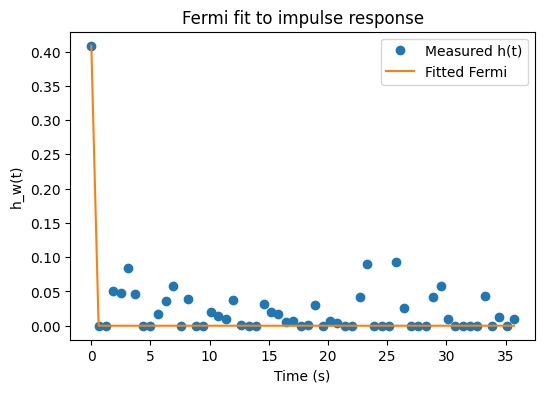

In [86]:
plt.figure(figsize=(6,4))
plt.plot(times_np, h_w, 'o', label='Measured h(t)')
plt.plot(times_np, fermi_impulse(times_np, *popt), '-', label='Fitted Fermi')
plt.xlabel("Time (s)")
plt.ylabel("h_w(t)")
plt.title("Fermi fit to impulse response")
plt.legend()
plt.show()

## All MYO pixels

In [ ]:


def next_pow2(x):
    return 1 << (int(x - 1).bit_length())

def wiener_deconv_all(aif, Y_tN, dt, alpha=1e-2):
    """
    Vectorized Wiener deconvolution for many curves at once.
    aif: (T,)
    Y_tN: (T, N) tissue curves (columns = pixels)
    returns h_tN: (T, N)
    """
    T, N = Y_tN.shape
    n = next_pow2(2*T)  # zero-pad to avoid circular wrap-around

    a_pad = np.pad(aif, (0, n - T))
    A = rfft(a_pad)                              # (F,)
    denom = (np.abs(A)**2 + alpha)               # (F,)

    Y_pad = np.pad(Y_tN, ((0, n - T), (0, 0)))   # (n, N)
    YF = rfft(Y_pad, axis=0)                     # (F, N)

    HF = (YF * np.conj(A)[:, None]) / denom[:, None]   # (F, N)
    h_tN = irfft(HF, n=n, axis=0)[:T, :] / dt          # back to time, scale by dt
    h_tN = np.clip(h_tN, 0, None)                      # non-negativity
    return h_tN

In [88]:
def fermi_impulse(t, F, t0, k, tau):
    # h(t) = F * exp(-(t - t0)/tau) / (1 + exp((t - t0)/k))
    t = np.asarray(t, dtype=np.float64)
    decay   = np.exp(-np.clip(t - t0, 0, None) / (tau + 1e-8))
    logistic= 1.0 / (1.0 + np.exp((t - t0) / (k + 1e-8)))
    return F * decay * logistic


def fit_fermi_per_pixel(t, h_col, aif_peak_t,
                        k_frac=0.1, tau_frac=0.2, maxfev=3000):
    """
    Fit F, t0, k, tau for one pixel's impulse response h_col (length T).
    aif_peak_t is a reasonable initial guess for arrival scale.
    """
    if not np.any(h_col > 0):
        return np.nan, (np.nan,)*4

    T = len(t)
    duration = t[-1] - t[0]
    F0   = max(h_col[0], np.max(h_col))
    t0_0 = max(0.0, aif_peak_t * 0.7)  # a bit before AIF peak
    k0   = max(1e-3, k_frac * duration)
    tau0 = max(1e-3, tau_frac * duration)
    p0   = (F0, t0_0, k0, tau0)
    bounds = ([0.0, 0.0, 1e-3, 1e-3], [np.inf, t[-1], t[-1], t[-1]])

    try:
        popt, _ = curve_fit(fermi_impulse, t, h_col, p0=p0, bounds=bounds, maxfev=maxfev)
        F, t0, k, tau = popt
        mbf = fermi_impulse(np.array([0.0]), F, t0, k, tau)[0]  # MBF = h_model(0)
        return mbf, popt
    except Exception:
        # Fallback: use h(0) as MBF estimate if fit fails
        return float(h_col[0]), (np.nan,)*4

In [89]:
vol_myo.shape

(58, 256, 192)

In [90]:
myo_mask.shape

(256, 192)

In [ ]:
dt_s = float(times_np[1] - times_np[0])
T, H, W = vol_myo.shape

# # Build matrix of myocardial curves only where mask is true
roi_idx = np.argwhere(myo_mask)
# N = roi_idx.shape[0]
# Y_tN = vol_myo[:, myo_mask].astype(np.float64)  # (T, N)

# print(aif_t.shape)
# print(Y_tN.shape)

# Ensure mask is boolean and 2-D
myo_mask = myo_mask.astype(bool)           # (H, W)

# Extract only masked pixels across time
T, H, W = vol_myo.shape
Y_tN = vol_myo[:, myo_mask]                # result: (T, N)
print(aif_t.shape)                         # (58,)
print(Y_tN.shape)                          # (58, N)  — good

# Deconvolution (vectorized)
alpha = 1e-2
h_tN = wiener_deconv_all(aif_t, Y_tN, dt_s, alpha=alpha)  # (T, N)

vol_myo = np.where(myo_mask, vol, 0)

# Initial guess helper: AIF peak time
aif_peak_t = times_np[int(np.argmax(aif_t))]

# Fit Fermi per pixel and assemble MBF map
mbf_map = np.full((H, W), np.nan, dtype=np.float32)
rho = 1.05  # g/mL

for col, (y, x) in enumerate(roi_idx):
    h_col = h_tN[:, col]
    mbf_h0_like, popt = fit_fermi_per_pixel(times_np, h_col, aif_peak_t)
    # Convert to mL/g/min
    mbf_map[y, x] = (mbf_h0_like * 60.0) / rho

(58,)
(58, 875)


/var/folders/8g/zqd199pn1g3dpm09tyy1t1lc0000gn/T/ipykernel_22700/1956576348.py:5: RuntimeWarning:

overflow encountered in exp



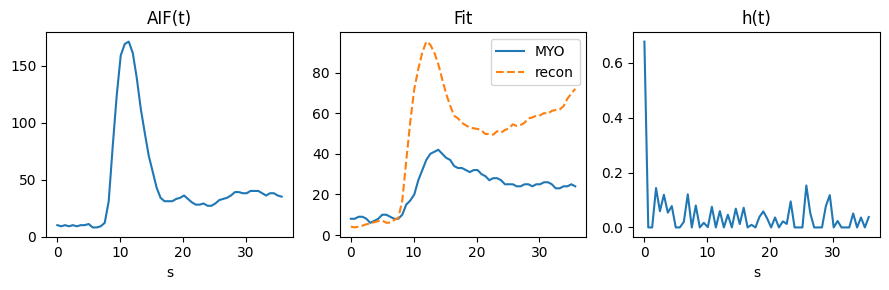

In [93]:
# Sanity check on a random ROI pixel
i = np.random.randint(0, N)
h_one = h_tN[:, i]
y_hat = np.convolve(aif_t, h_one)[:T] * dt_s

import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.plot(times_np, aif_t); plt.title("AIF(t)"); plt.xlabel("s")
plt.subplot(1,3,2); plt.plot(times_np, Y_tN[:, i], label="MYO"); plt.plot(times_np, y_hat, '--', label="recon"); plt.legend(); plt.title("Fit")
plt.subplot(1,3,3); plt.plot(times_np, h_one); plt.title("h(t)"); plt.xlabel("s")
plt.tight_layout(); plt.show()


## MBF map

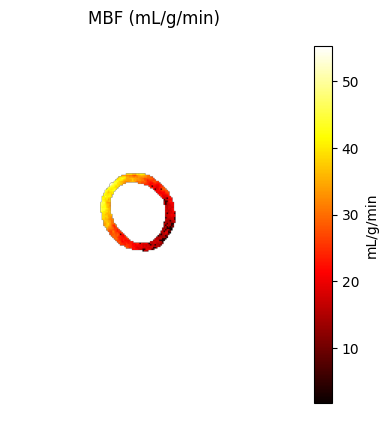

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
im = plt.imshow(mbf_map, cmap="hot")
plt.title("MBF (mL/g/min)")
plt.axis("off")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("mL/g/min")
plt.show()
